In [1]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
df = pd.read_csv(r"./data/bank_data.csv")
df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
df.shape

(10127, 22)

In [5]:
df.dtypes

Unnamed: 0                    int64
CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [6]:
df.isnull().sum()

Unnamed: 0                  0
CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [7]:
result = (df.isnull().sum() > 0).any()
result

False

In [8]:
type(df.isnull().sum())

pandas.core.series.Series

In [9]:
df.describe()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,5063.000000,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,2923.557422,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,2531.500000,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,5063.000000,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7594.500000,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,10126.000000,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [10]:
df.dtypes

Unnamed: 0                    int64
CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [11]:
df_cat_cols = df.select_dtypes(include=['object']).columns
print(df_cat_cols.tolist())

['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [12]:
df_num_cols = df.select_dtypes(exclude=['object']).columns
print(df_num_cols.tolist())

['Unnamed: 0', 'CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [13]:
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category' ,
    'Attrition_Flag'
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

In [14]:
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

In [15]:

# df['Attrition_Flag'].hist()

# plt.ylabel('count')
# plt.xlabel('Attrition_Flag')
# plt.savefig(r'./images/eda/attrition_flag_hist.jpg')

In [16]:
# df[df['Attrition_Flag'] == 'Attrited Customer']

In [17]:
# df[df['Attrition_Flag'] == 'Attrited Customer'].describe()

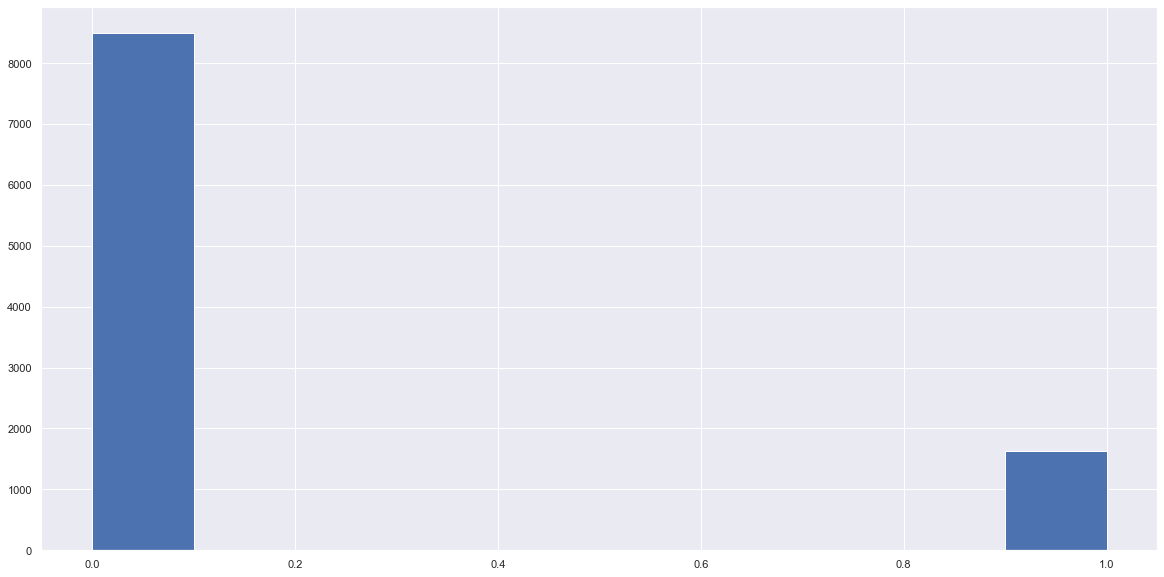

In [18]:
plt.figure(figsize=(20,10)) 
df['Churn'].hist();

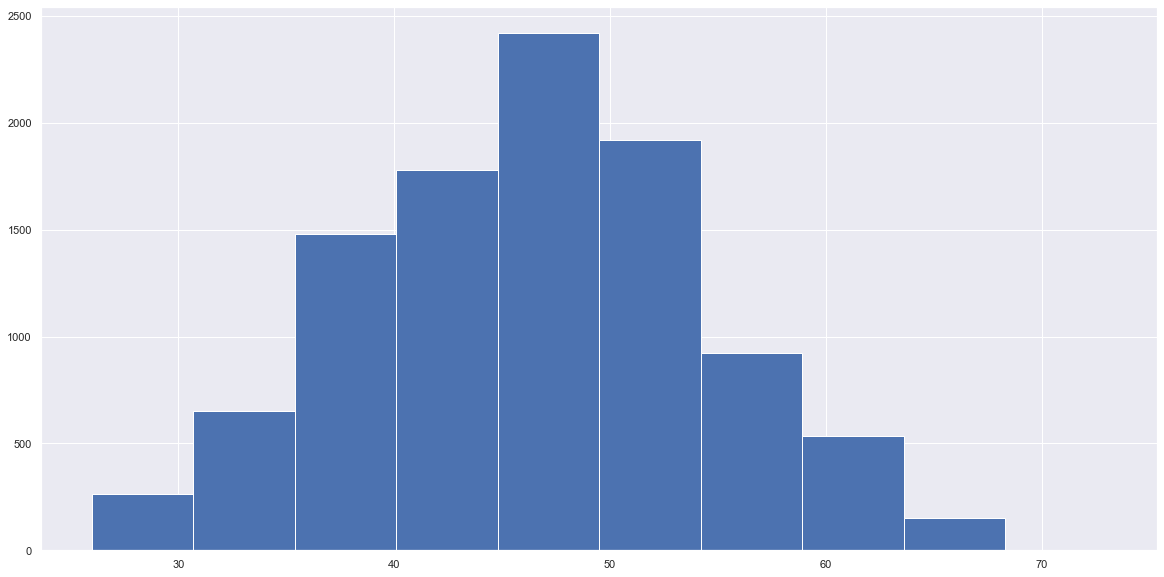

In [19]:
plt.figure(figsize=(20,10)) 
df['Customer_Age'].hist();

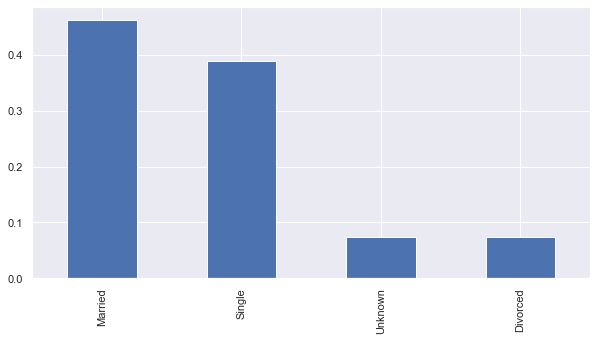

In [20]:
plt.figure(figsize=(10,5)) 
#df.Marital_Status.value_counts('normalize').plot(kind='bar');

df.Marital_Status.value_counts('normalize').plot(kind='bar');

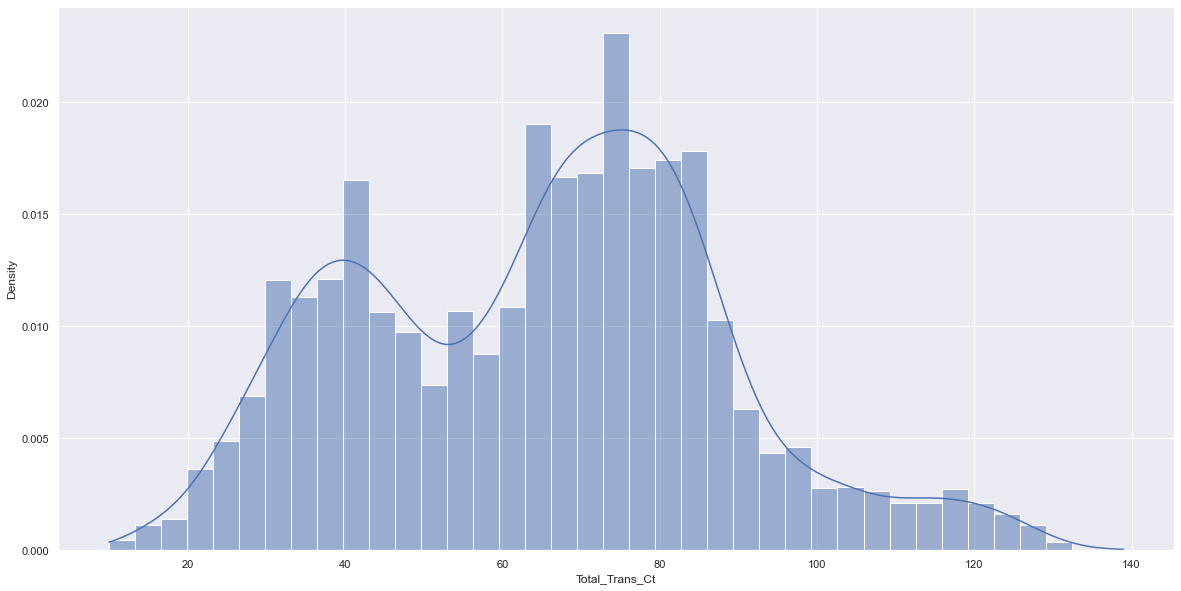

In [21]:
plt.figure(figsize=(20,10)) 
# distplot is deprecated. Use histplot instead
# sns.distplot(df['Total_Trans_Ct']);
# Show distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
fig = sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True)

In [76]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True)

# plt.title('Histogram with KDE for Total Transactions Count')
# #plt.savefig(constants.EDA_IMAGE_PATH + '/Total_Trans_Ct_histplot.jpg')

# plt.savefig(r'./images/eda/Total_Trans_Ct_density.jpg')


In [77]:
# Encode categorical columns to numeric values
# label_encoder = LabelEncoder()
# df2 = df.copy(deep=True)

# for column in cat_columns:
#     df2[column] = label_encoder.fit_transform(df2[column])

# df2.head(5)

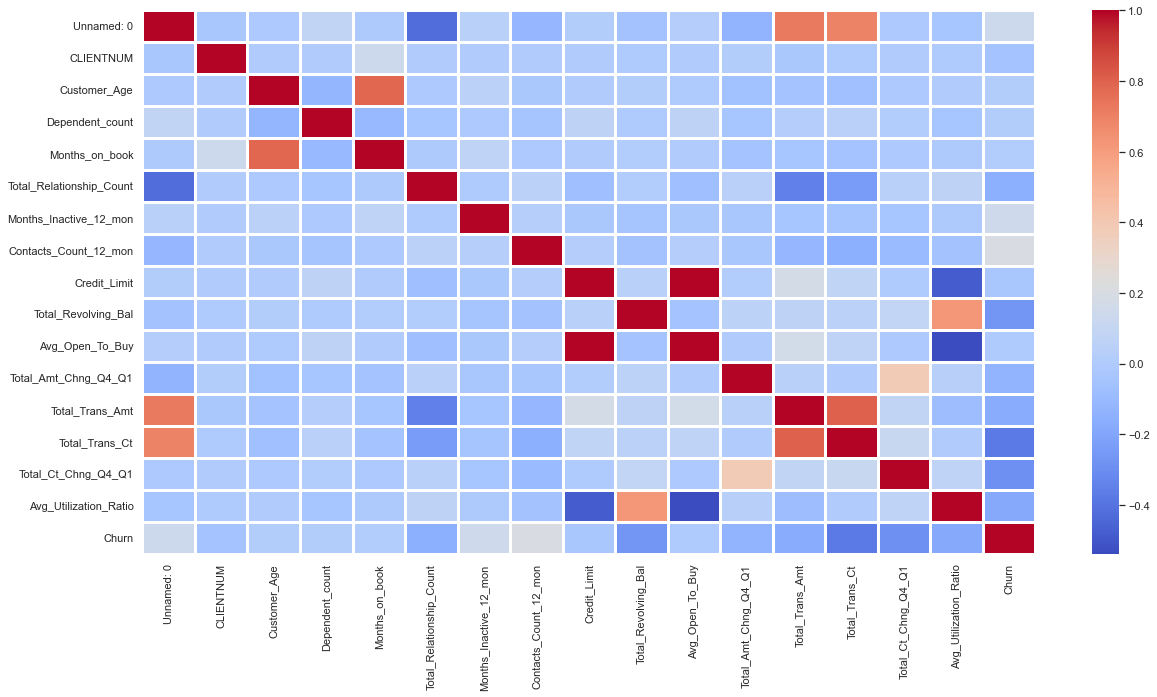

In [22]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths = 2)
plt.show()

In [23]:
print(id(df))

2139778725200


In [24]:
y = df['Churn']

In [25]:
X = pd.DataFrame()

In [26]:
# gender encoded column
gender_lst = []
gender_groups = df.groupby('Gender').mean()['Churn']

for val in df['Gender']:
    gender_lst.append(gender_groups.loc[val])

df['Gender_Churn'] = gender_lst    
#education encoded column
edu_lst = []
edu_groups = df.groupby('Education_Level').mean()['Churn']

for val in df['Education_Level']:
    edu_lst.append(edu_groups.loc[val])

df['Education_Level_Churn'] = edu_lst

#marital encoded column
marital_lst = []
marital_groups = df.groupby('Marital_Status').mean()['Churn']

for val in df['Marital_Status']:
    marital_lst.append(marital_groups.loc[val])

df['Marital_Status_Churn'] = marital_lst

#income encoded column
income_lst = []
income_groups = df.groupby('Income_Category').mean()['Churn']

for val in df['Income_Category']:
    income_lst.append(income_groups.loc[val])

df['Income_Category_Churn'] = income_lst

#card encoded column
card_lst = []
card_groups = df.groupby('Card_Category').mean()['Churn']
 
for val in df['Card_Category']:
    card_lst.append(card_groups.loc[val])

df['Card_Category_Churn'] = card_lst
    
    

In [27]:
df.head(5)

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1144,42,1.625,0.061,0,0.146152,0.152012,0.151269,0.134807,0.160979
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1291,33,3.714,0.105,0,0.173572,0.155691,0.169414,0.171862,0.160979
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1887,20,2.333,0.000,0,0.146152,0.155691,0.151269,0.157655,0.160979
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,1171,20,2.333,0.760,0,0.173572,0.152012,0.172230,0.171862,0.160979
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,816,28,2.500,0.000,0,0.146152,0.159381,0.151269,0.134807,0.160979


In [28]:
df.dtypes

Unnamed: 0                    int64
CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
Churn                         int64
Gender_Churn                float64
Education_Level_Churn       float64
Marital_Status_Churn        float64
Income_Category_Churn       float64
Card_Category_Churn         

In [29]:
keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

X[keep_cols] = df[keep_cols]

In [30]:
X.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.146152,0.152012,0.151269,0.134807,0.160979
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.173572,0.155691,0.169414,0.171862,0.160979
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.146152,0.155691,0.151269,0.157655,0.160979
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.173572,0.152012,0.172230,0.171862,0.160979
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.146152,0.159381,0.151269,0.134807,0.160979


In [31]:
# This cell may take up to 15-20 minutes to run
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

# grid search
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2543
           1       0.71      0.45      0.55       496

    accuracy                           0.88      3039
   macro avg       0.81      0.71     

In [32]:
# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))


random forest results
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088


logistic regression results
test results
{'0': {'precision': 0.8998532648569333, 'recall': 0.9646087298466378, 'f1-score': 0.931106471816284, 'support': 2543}, '1': {'precision': 0.7124600638977636, 'recall': 0.4495967741935484, 'f1-score': 0.5512978986402965, 'support': 496}, 'accuracy': 0.8805528134254689, 'macro avg': {'precision': 0.8061566643773485, 'recall': 0.7071027520200931, 'f1-score': 0.7412021852282903, 'support': 3039}, 'weighted avg': {'precision': 0.8692685239303956, 'recall': 0.8805528134254689, 'f1-score': 0.8691173134433687, 'support': 3039}}


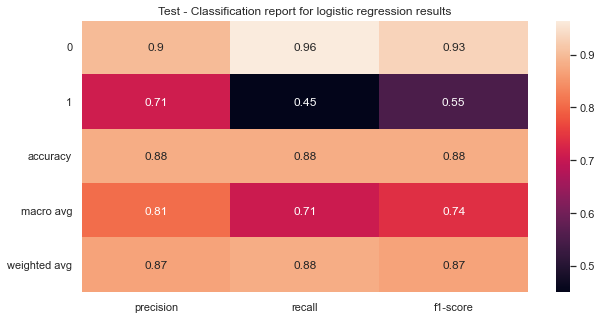

train results
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5957
           1       0.72      0.50      0.59      1131

    accuracy                           0.89      7088
   macro avg       0.82      0.73      0.76      7088
weighted avg       0.88      0.89      0.88      7088


In [33]:

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr,output_dict=True))
plt.figure(figsize=(10,5))
plt.title('Test - Classification report for logistic regression results')
sns.heatmap(pd.DataFrame(classification_report(y_test, y_test_preds_lr, output_dict=True)).iloc[:-1, :].T,annot=True)
plt.show()
print('train results')
print(classification_report(y_train, y_train_preds_lr))

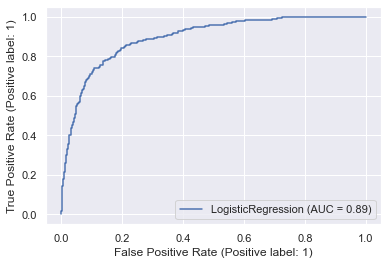

In [34]:
#lrc_plot = RocCurveDisplay.from_estimator(lrc, X_test, y_test)

lrc_plot = plot_roc_curve(lrc, X_test, y_test)

In [35]:
#lrc_fig = lrc_plot.figure_


#lrc_plot.figure_.savefig(constants.CLR_IMAGE_PATH + '/lrc_roc.png')

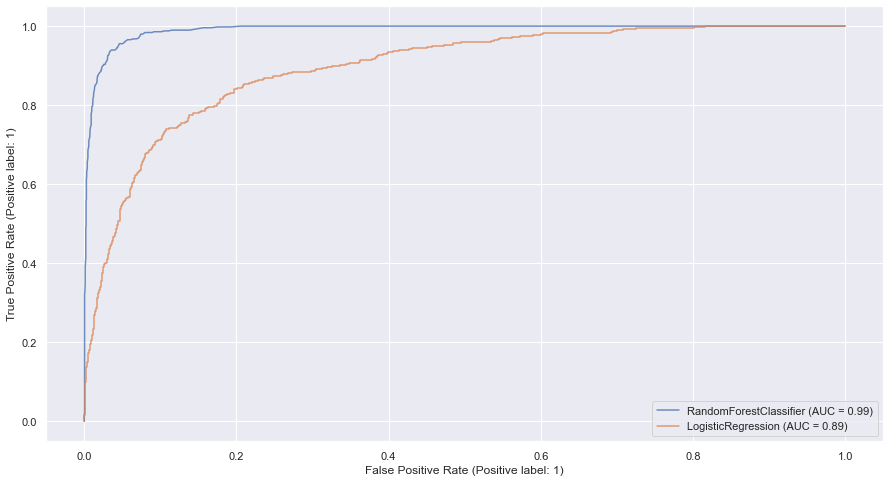

In [36]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [102]:
#rfc_disp.figure_.savefig(constants.CLR_IMAGE_PATH + '/rfc_roc.png', bbox_inches='tight')

In [37]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/logistic_model.pkl')

['./models/logistic_model.pkl']

In [38]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')

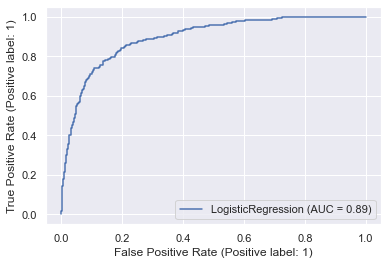

In [39]:
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

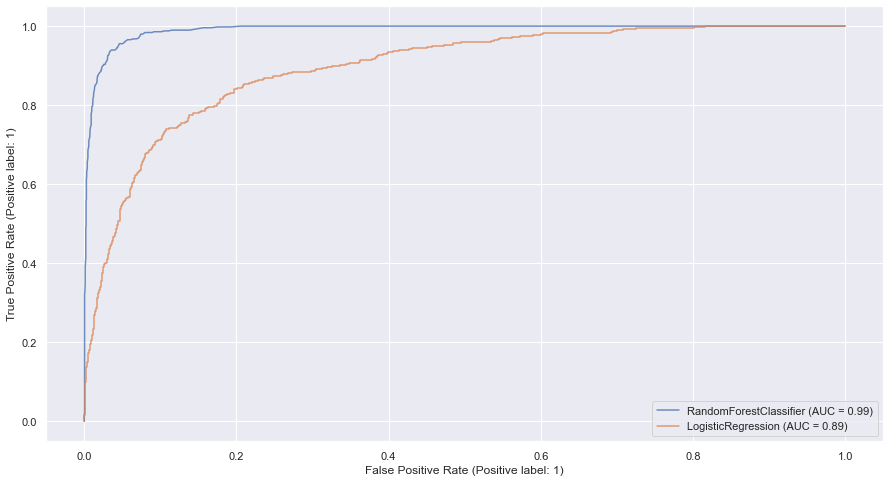

In [40]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [41]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)


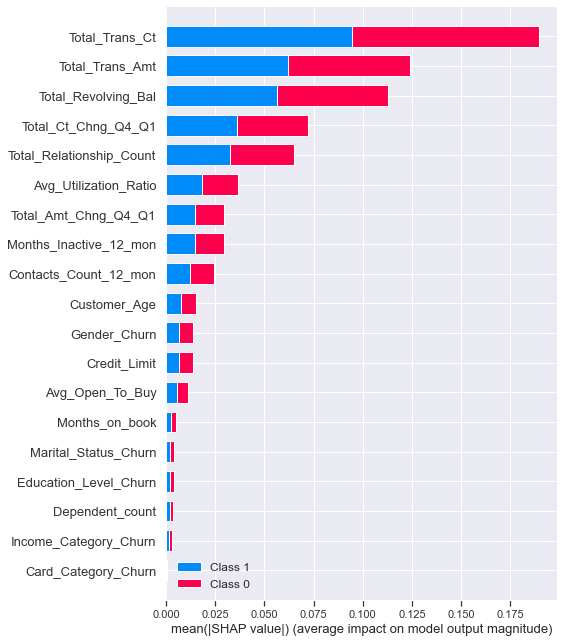

In [42]:
# Generate summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# Save the manually captured figure as an image (e.g., PNG)
plt.savefig('shap_summary_plot.png')

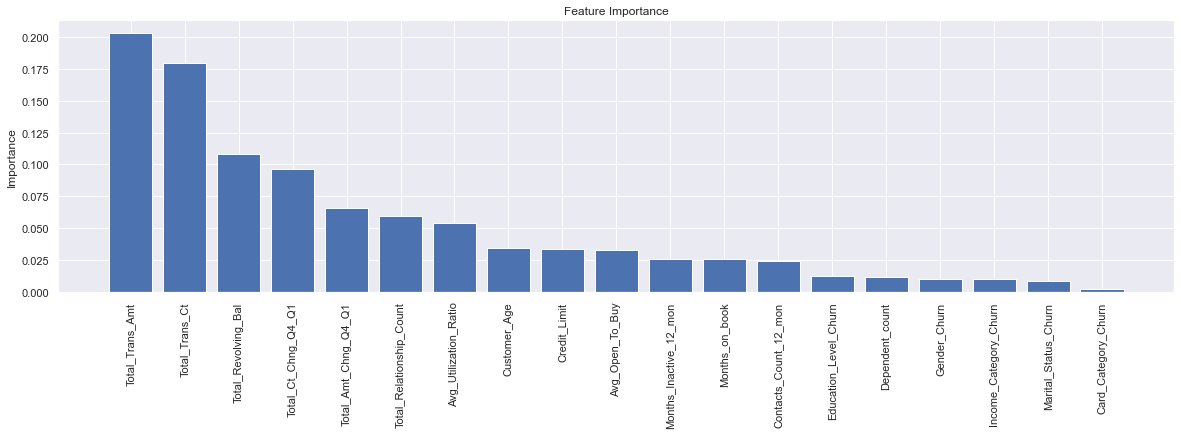

In [43]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

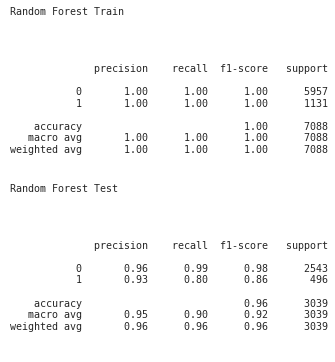

In [44]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


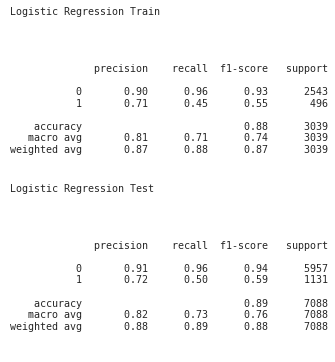

In [45]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');